# Approach #1 - Linear Regression

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os
import requests
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

## Data Fetching

In [ ]:
STOCK = "AAPL"
data = yf.download(STOCK, period="max")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600


## Data Analysis

In [ ]:
print("Check for missing values:")
print(data.isnull().sum())
print("Statistics:")
print(data.describe())
print("Data types:")
print(data.dtypes)

Check for missing values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Statistics:
               Open          High           Low         Close     Adj Close  \
count  10985.000000  10985.000000  10985.000000  10985.000000  10985.000000   
mean      22.058441     22.296786     21.831244     22.073604     21.279287   
std       45.494774     45.986282     45.042357     45.536175     45.103738   
min        0.049665      0.049665      0.049107      0.049107      0.037900   
25%        0.297991      0.303571      0.290179      0.297991      0.242029   
50%        0.529018      0.536429      0.518214      0.529018      0.429639   
75%       20.093214     20.268213     19.878571     20.045713     17.226709   
max      231.311707    233.080002    229.250000    232.979996    232.979996   

             Volume  
count  1.098500e+04  
mean   3.183976e+08  
std    3.355240e+08  
min    0.000000e+00  
25%    1.134448e+08  
50%    2.059792

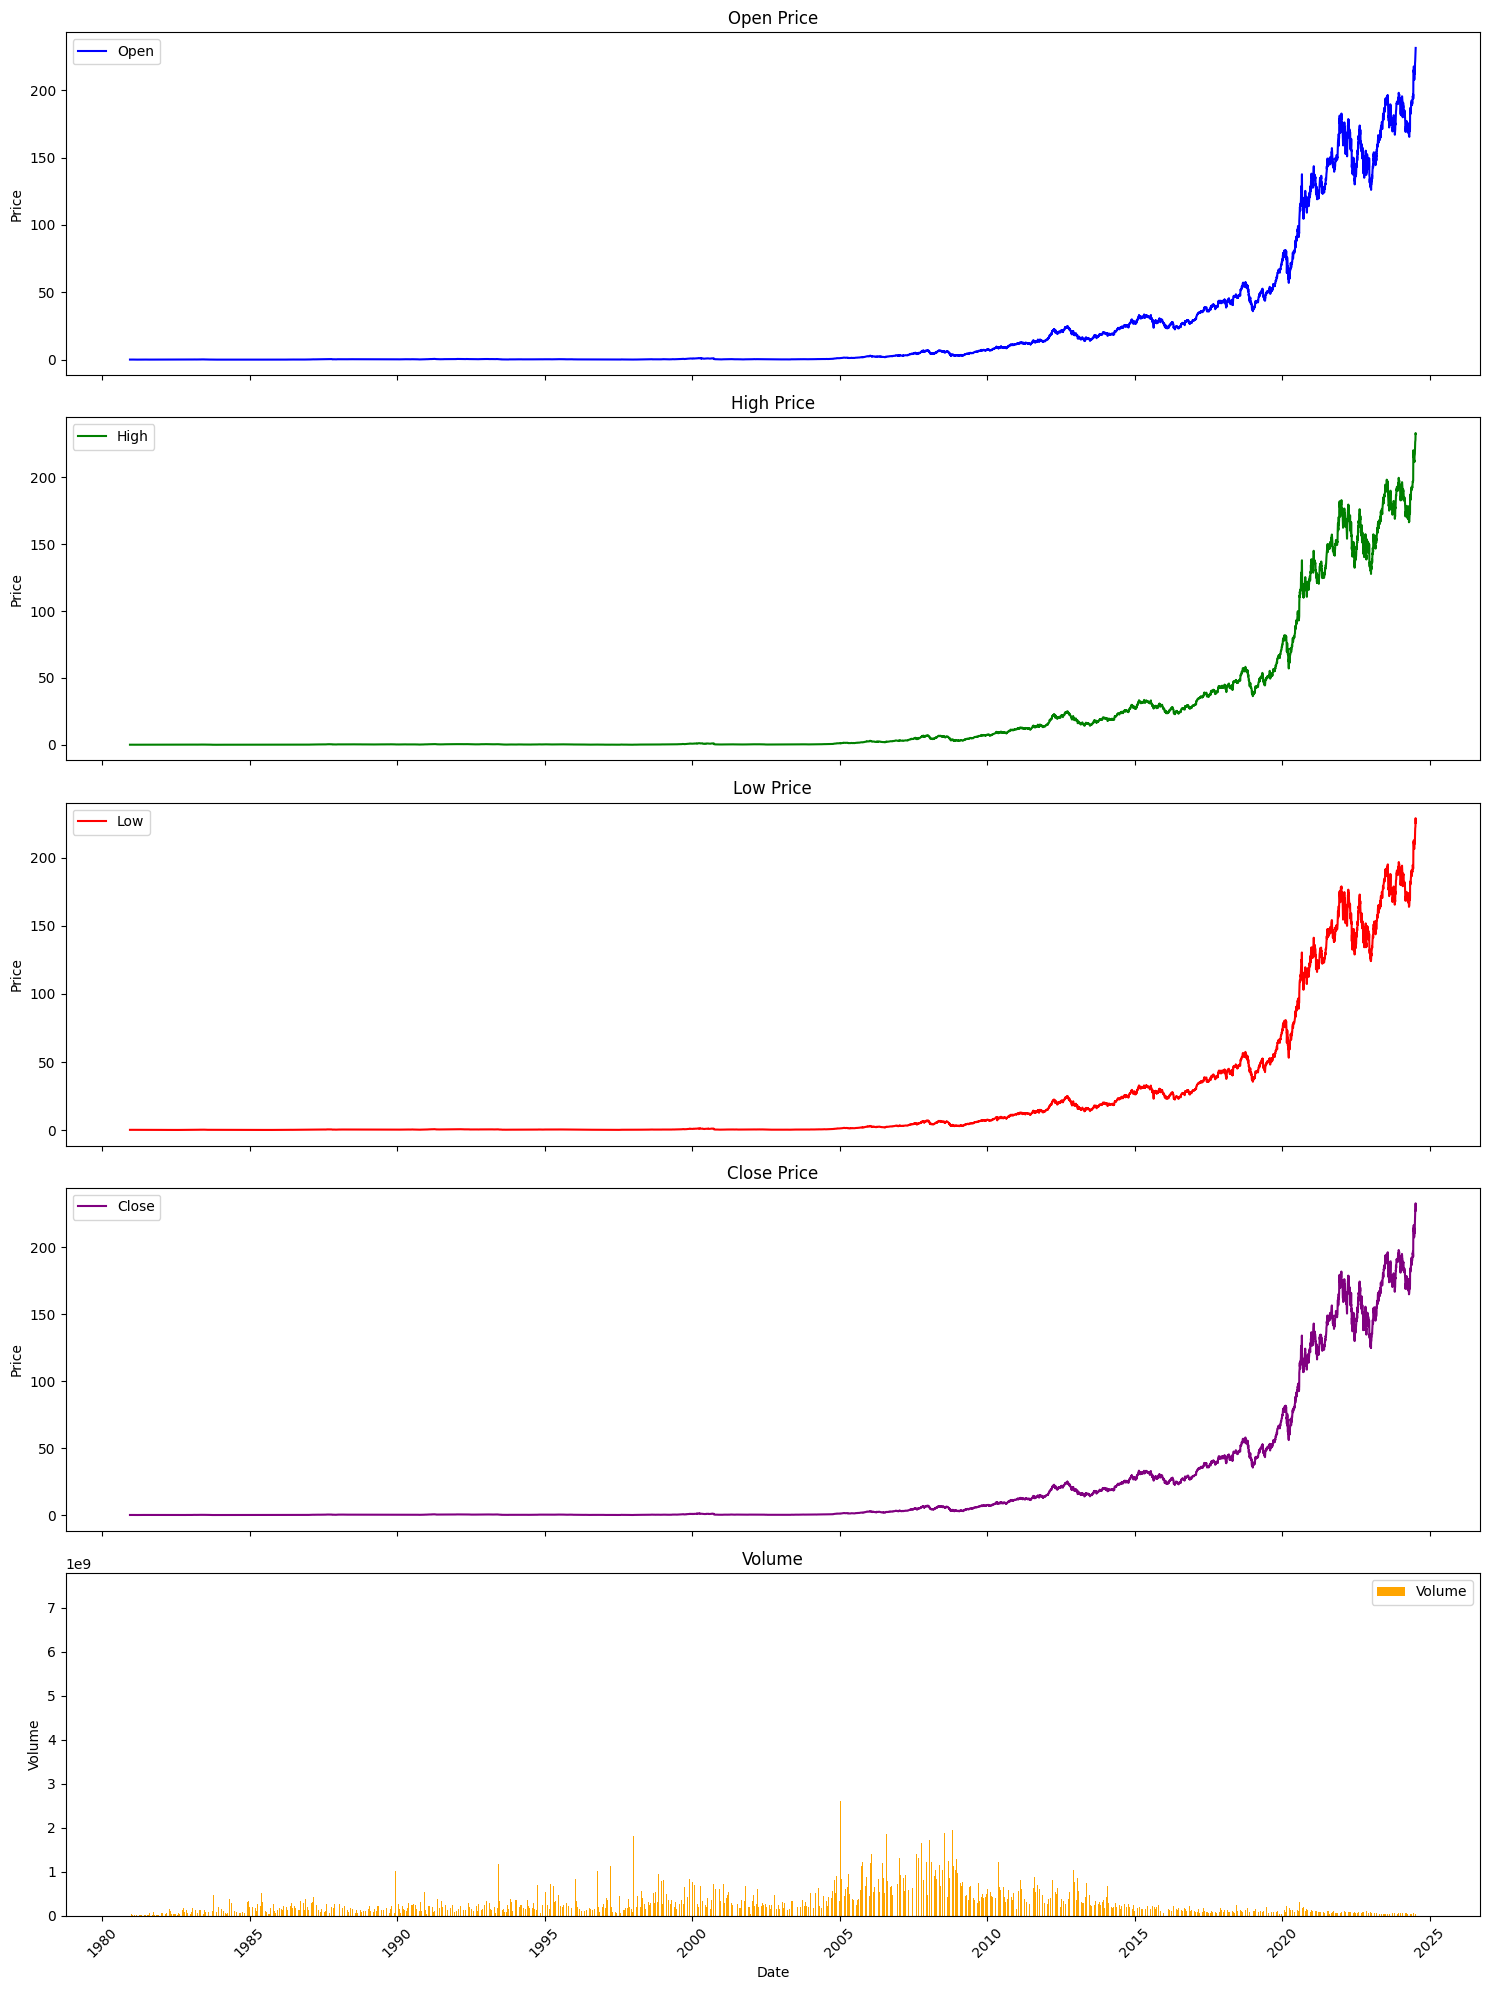

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

# Plot Open
axs[0].plot(data.index, data['Open'], label='Open', color='blue')
axs[0].set_title('Open Price')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot High
axs[1].plot(data.index, data['High'], label='High', color='green')
axs[1].set_title('High Price')
axs[1].set_ylabel('Price')
axs[1].legend()

# Plot Low
axs[2].plot(data.index, data['Low'], label='Low', color='red')
axs[2].set_title('Low Price')
axs[2].set_ylabel('Price')
axs[2].legend()

# Plot Close
axs[3].plot(data.index, data['Close'], label='Close', color='purple')
axs[3].set_title('Close Price')
axs[3].set_ylabel('Price')
axs[3].legend()

# Plot Volume
axs[4].bar(data.index, data['Volume'], label='Volume', color='orange')
axs[4].set_title('Volume')
axs[4].set_ylabel('Volume')
axs[4].legend()

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Outliers in Open:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-02   50.145000   52.095001   50.087502   51.847500   49.287628   
2018-08-03   51.757500   52.185001   51.369999   51.997501   49.430233   
2018-08-06   52.000000   52.312500   51.767502   52.267502   49.686882   
2018-08-07   52.330002   52.375000   51.689999   51.777500   49.221081   
2018-08-08   51.512501   51.952499   51.130001   51.812500   49.254353   
...                ...         ...         ...         ...         ...   
2024-07-05  221.649994  226.449997  221.649994  226.339996  226.339996   
2024-07-08  227.089996  227.850006  223.250000  227.820007  227.820007   
2024-07-09  227.929993  229.399994  226.369995  228.679993  228.679993   
2024-07-10  229.300003  233.080002  229.250000  232.979996  232.979996   
2024-07-11  231.311707  232.389999  225.770004  227.570007  227.570007   

               Vol

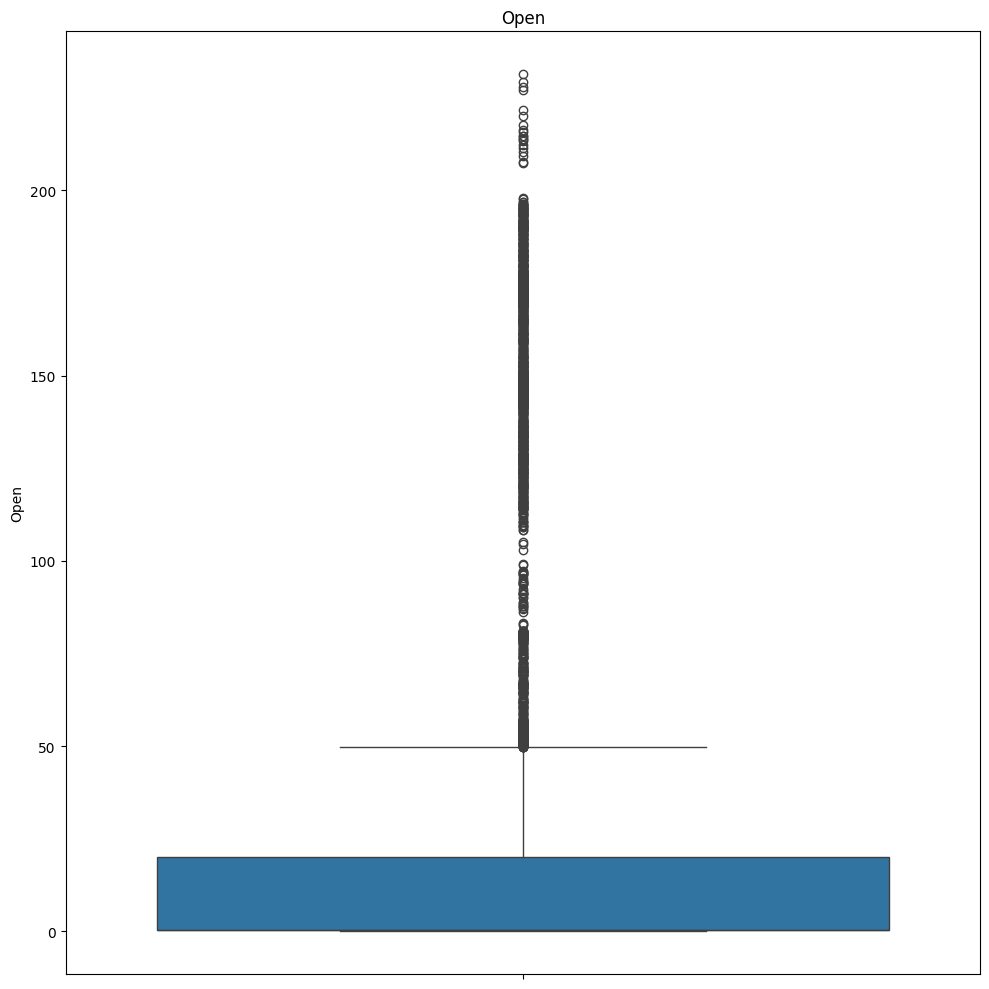

Outliers in High:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-01   49.782501   50.439999   49.327499   50.375000   47.887829   
2018-08-02   50.145000   52.095001   50.087502   51.847500   49.287628   
2018-08-03   51.757500   52.185001   51.369999   51.997501   49.430233   
2018-08-06   52.000000   52.312500   51.767502   52.267502   49.686882   
2018-08-07   52.330002   52.375000   51.689999   51.777500   49.221081   
...                ...         ...         ...         ...         ...   
2024-07-05  221.649994  226.449997  221.649994  226.339996  226.339996   
2024-07-08  227.089996  227.850006  223.250000  227.820007  227.820007   
2024-07-09  227.929993  229.399994  226.369995  228.679993  228.679993   
2024-07-10  229.300003  233.080002  229.250000  232.979996  232.979996   
2024-07-11  231.311707  232.389999  225.770004  227.570007  227.570007   

               Vol

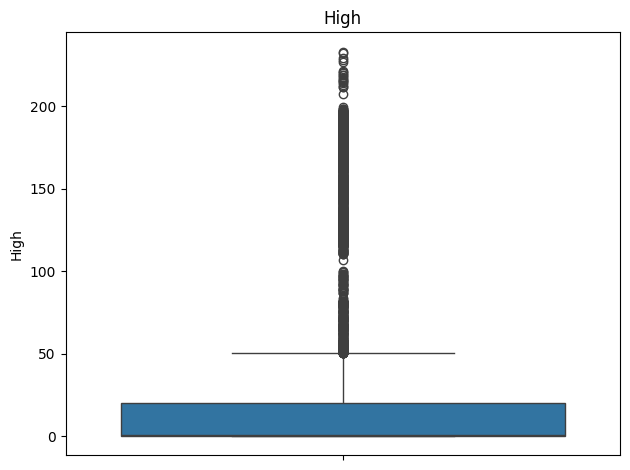

Outliers in Low:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-01   49.782501   50.439999   49.327499   50.375000   47.887829   
2018-08-02   50.145000   52.095001   50.087502   51.847500   49.287628   
2018-08-03   51.757500   52.185001   51.369999   51.997501   49.430233   
2018-08-06   52.000000   52.312500   51.767502   52.267502   49.686882   
2018-08-07   52.330002   52.375000   51.689999   51.777500   49.221081   
...                ...         ...         ...         ...         ...   
2024-07-05  221.649994  226.449997  221.649994  226.339996  226.339996   
2024-07-08  227.089996  227.850006  223.250000  227.820007  227.820007   
2024-07-09  227.929993  229.399994  226.369995  228.679993  228.679993   
2024-07-10  229.300003  233.080002  229.250000  232.979996  232.979996   
2024-07-11  231.311707  232.389999  225.770004  227.570007  227.570007   

               Volu

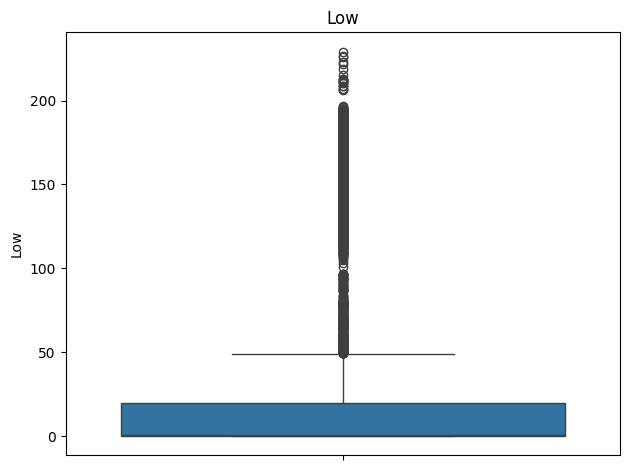

Outliers in Close:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-01   49.782501   50.439999   49.327499   50.375000   47.887829   
2018-08-02   50.145000   52.095001   50.087502   51.847500   49.287628   
2018-08-03   51.757500   52.185001   51.369999   51.997501   49.430233   
2018-08-06   52.000000   52.312500   51.767502   52.267502   49.686882   
2018-08-07   52.330002   52.375000   51.689999   51.777500   49.221081   
...                ...         ...         ...         ...         ...   
2024-07-05  221.649994  226.449997  221.649994  226.339996  226.339996   
2024-07-08  227.089996  227.850006  223.250000  227.820007  227.820007   
2024-07-09  227.929993  229.399994  226.369995  228.679993  228.679993   
2024-07-10  229.300003  233.080002  229.250000  232.979996  232.979996   
2024-07-11  231.311707  232.389999  225.770004  227.570007  227.570007   

               Vo

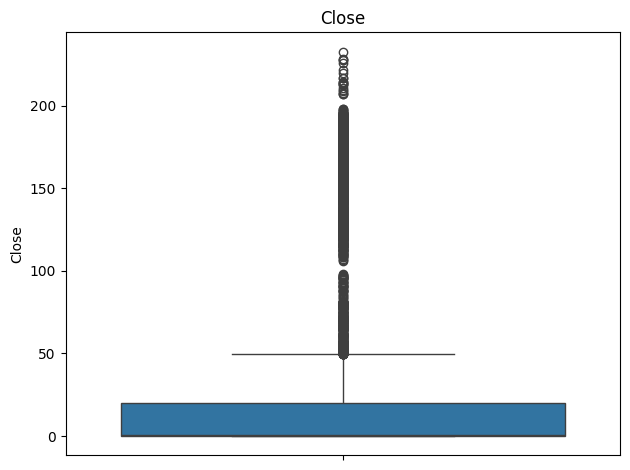

Outliers in Volume:
                  Open       High        Low      Close  Adj Close      Volume
Date                                                                         
1983-09-23   0.111607   0.111607   0.099330   0.108259   0.083553  2832345600
1983-11-08   0.087054   0.087054   0.077009   0.079799   0.061588  1221516800
1986-03-20   0.125000   0.132254   0.125000   0.126116   0.097335   904131200
1986-11-25   0.169643   0.180246   0.169643   0.179688   0.138681   848960000
1989-01-27   0.341518   0.350446   0.323661   0.335938   0.262786  2127171200
...               ...        ...        ...        ...        ...         ...
2013-04-17  15.009643  15.021429  14.218214  14.385714  12.341962   945056000
2013-04-24  14.055000  14.830357  14.017857  14.480714  12.423467   969651200
2013-08-13  16.819286  17.666430  16.716070  17.484644  15.199627   881941200
2013-09-11  16.678928  16.917500  16.600357  16.703930  14.520943   898696400
2014-01-28  18.170000  18.392857  17.931070

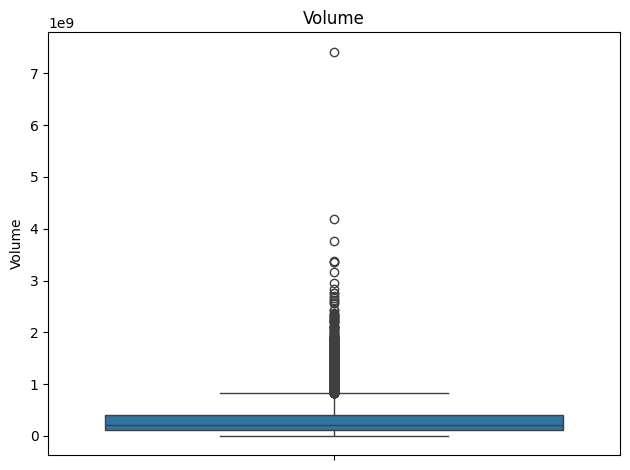

In [ ]:
import seaborn as sns

def detect_outliers(column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

plt.figure(figsize=(10, 10))
price_columns = ['Open', 'High', 'Low', 'Close', "Volume"]
for i, column in enumerate(price_columns):
    outliers = detect_outliers(column)
    if not outliers.empty:
      print(f"Outliers in {column}:\n", outliers)
      sns.boxplot(data[column])
      plt.title(f'{column.capitalize()}')
      plt.tight_layout()
      plt.show()

In [ ]:
data.index = pd.to_datetime(data.index)

# Define the cutoff date
cutoff_date = '2012-01-01'

# Filter the DataFrame
filtered_data = data[data.index >= cutoff_date]

Outliers in Volume:
                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-01-24  15.182143  15.182143  14.983929  15.014643  12.694171  547638000
2012-01-25  16.230000  16.230356  15.847500  15.952143  13.486784  958314000
2012-02-09  17.170000  17.741072  17.162857  17.613214  14.891140  884214800
2012-02-10  17.534286  17.772142  17.448214  17.622143  14.898687  631302000
2012-02-13  17.840357  17.993929  17.753214  17.950001  15.175884  517216000
...               ...        ...        ...        ...        ...        ...
2015-08-24  23.717501  27.200001  23.000000  25.780001  23.308506  648825200
2016-01-27  24.010000  24.157499  23.334999  23.355000  21.206371  533478800
2016-04-27  24.000000  24.677500  23.920000  24.455000  22.325661  458408400
2016-09-14  27.182501  28.257500  27.150000  27.942499  25.803841  443554800
2017-02-01  31.757500  32.622501  31.752501  32.187500 

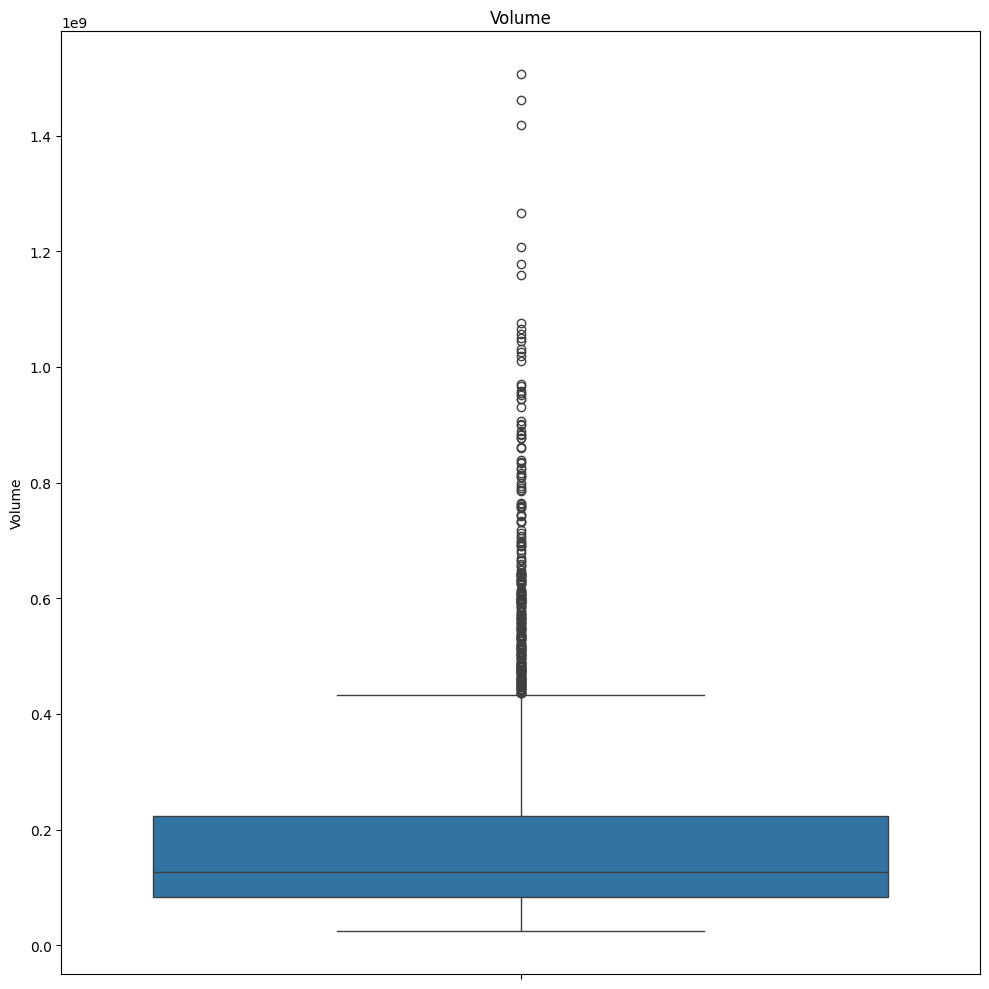

In [ ]:
import seaborn as sns

def detect_outliers(column):
    Q1 = filtered_df[column].quantile(0.25)
    Q3 = filtered_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return filtered_df[(filtered_df[column] < lower_bound) | (filtered_df[column] > upper_bound)]

plt.figure(figsize=(10, 10))
price_columns = ['Open', 'High', 'Low', 'Close', "Volume"]
for i, column in enumerate(price_columns):
    outliers = detect_outliers(column)
    if not outliers.empty:
      print(f"Outliers in {column}:\n", outliers)
      sns.boxplot(filtered_df[column])
      plt.title(f'{column.capitalize()}')
      plt.tight_layout()
      plt.show()

In [ ]:
data = filtered_df

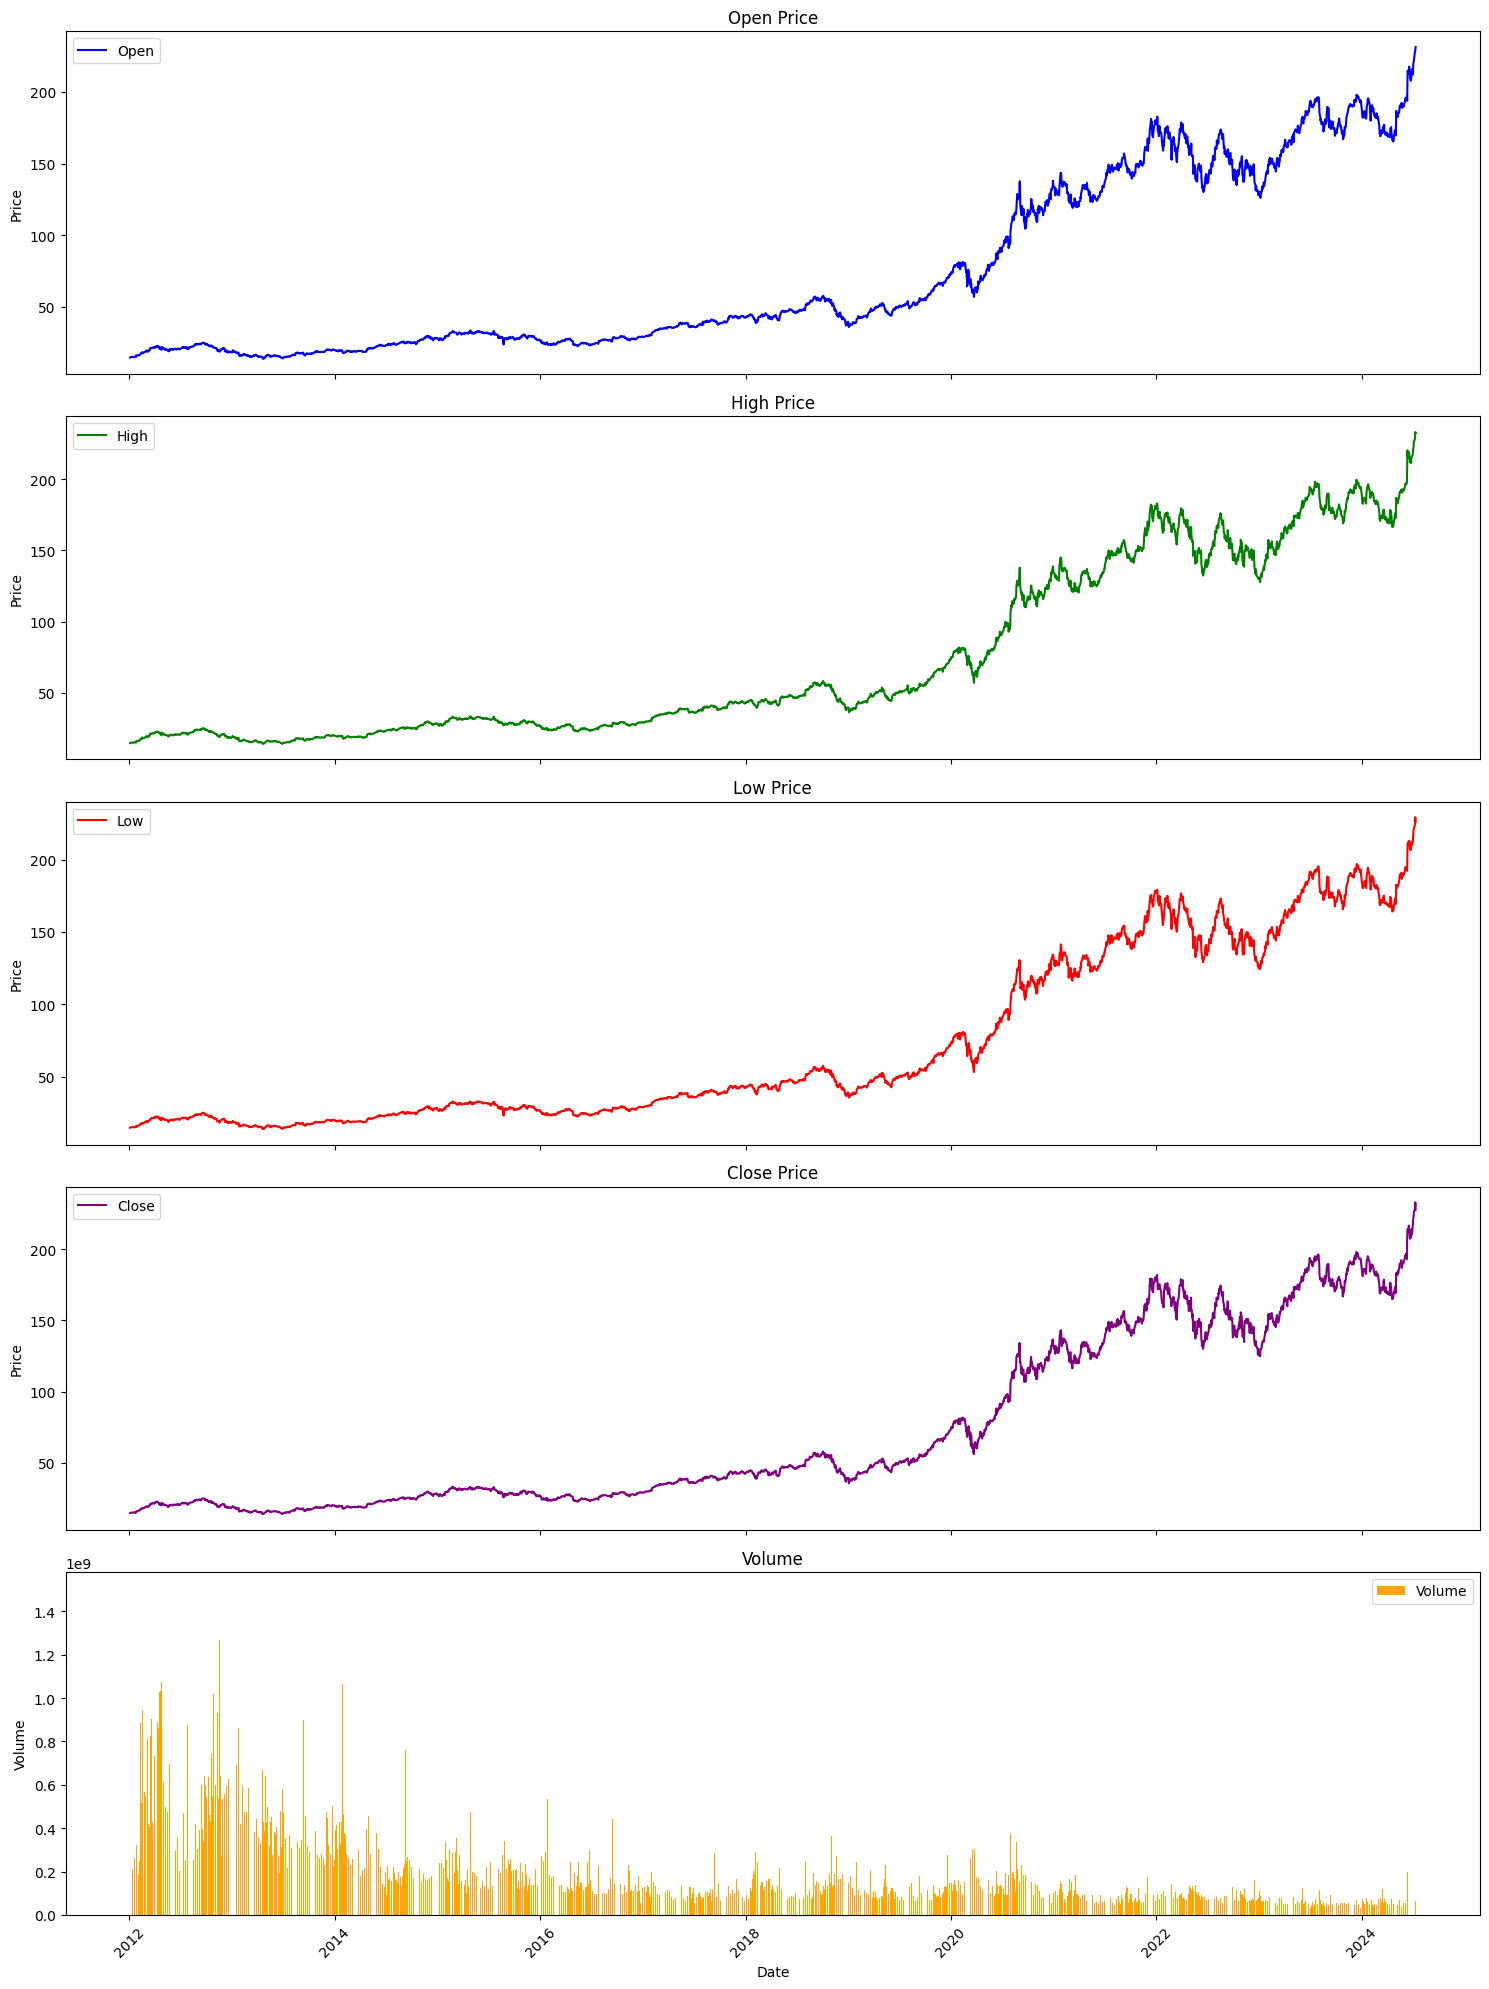

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

# Plot Open
axs[0].plot(data.index, data['Open'], label='Open', color='blue')
axs[0].set_title('Open Price')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot High
axs[1].plot(data.index, data['High'], label='High', color='green')
axs[1].set_title('High Price')
axs[1].set_ylabel('Price')
axs[1].legend()

# Plot Low
axs[2].plot(data.index, data['Low'], label='Low', color='red')
axs[2].set_title('Low Price')
axs[2].set_ylabel('Price')
axs[2].legend()

# Plot Close
axs[3].plot(data.index, data['Close'], label='Close', color='purple')
axs[3].set_title('Close Price')
axs[3].set_ylabel('Price')
axs[3].legend()

# Plot Volume
axs[4].bar(data.index, data['Volume'], label='Volume', color='orange')
axs[4].set_title('Volume')
axs[4].set_ylabel('Volume')
axs[4].legend()

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
data['year'] = data.index.year
data['month'] = data.index.month

yearly_data = {}
for year in range(2012, 2025):
  df_year = data[data['year'] == year]
  result = df_year.groupby(['month']).agg(
      open=('Open', 'first'),
      high=('High', 'max'),
      low=('Low', 'min'),
      close=('Close', 'last')
  ).reset_index()
  yearly_data[year] = result

<ipython-input-12-7f8ffc6e194c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data.index.year
<ipython-input-12-7f8ffc6e194c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data.index.month


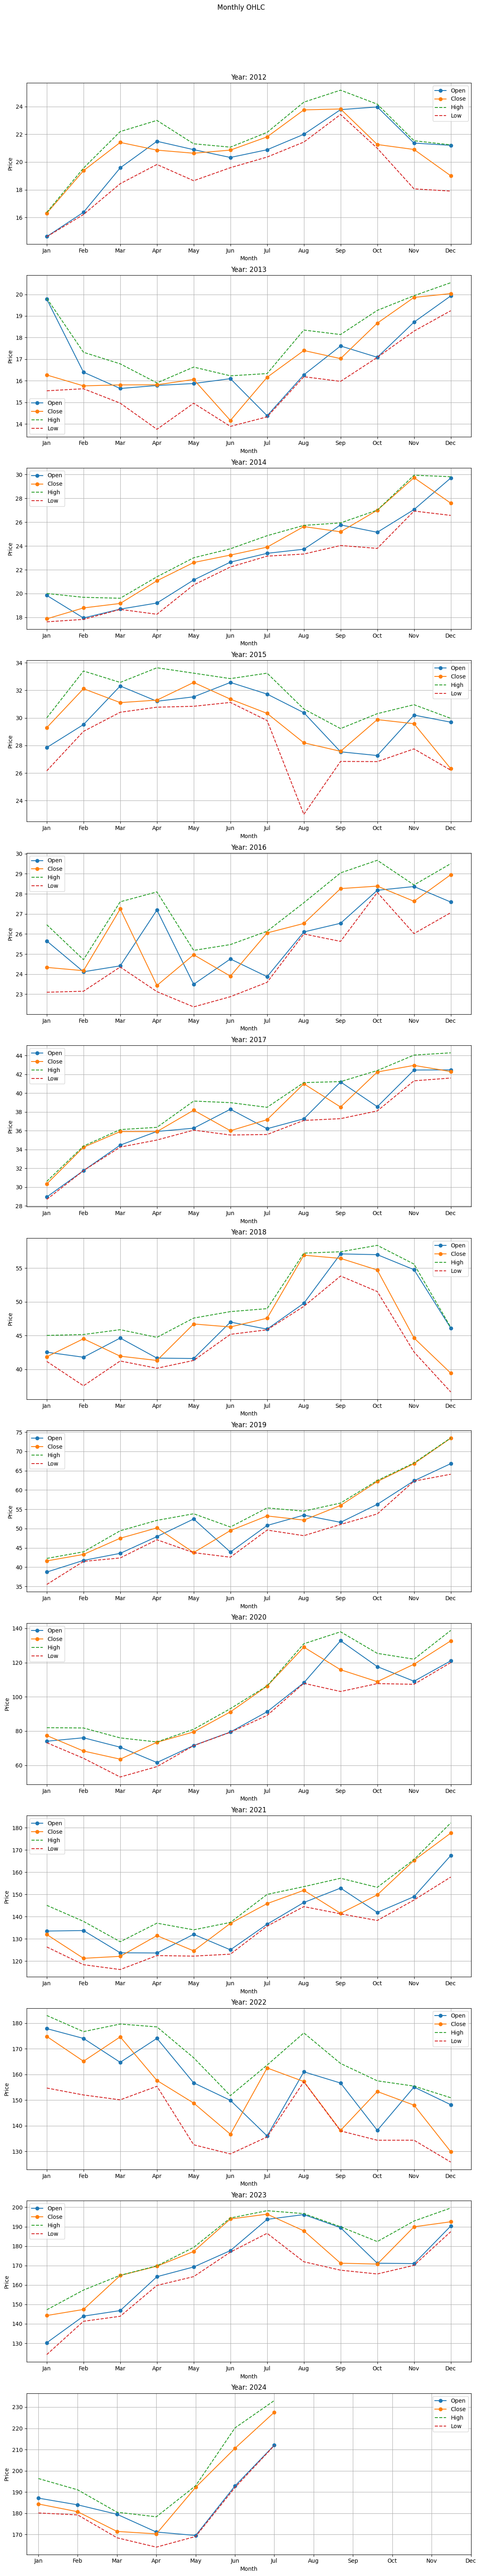

In [ ]:
years = list(yearly_data.keys())
num_plots = len(yearly_data)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, num_plots*5))
fig.suptitle(f' Monthly OHLC')
for i, year in enumerate(years):
    ax = axes[i]
    result = yearly_data[year]
    ax.plot(result['month'], result['open'], label='Open', marker='o')
    ax.plot(result['month'], result['close'], label='Close', marker='o')
    ax.plot(result['month'], result['high'], label='High', linestyle='--')
    ax.plot(result['month'], result['low'], label='Low', linestyle='--')
    ax.set_title(f'Year: {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Price')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999888,0.999882,0.999743,0.999704,-0.503800
High,0.999888,1.000000,0.999848,0.999880,0.999834,-0.502624
Low,0.999882,0.999848,1.000000,0.999881,0.999855,-0.505476
Close,0.999743,0.999880,0.999881,1.000000,0.999961,-0.504184
Adj Close,0.999704,0.999834,0.999855,0.999961,1.000000,-0.505602
Volume,-0.503800,-0.502624,-0.505476,-0.504184,-0.505602,1.000000


## Data Preprocessing

## Approach 1.1 - Single Lagged Feature

In [ ]:
dataset = data[['Close']]

# Create lagged features
look_back = 5
for i in range(1, look_back + 1):
    dataset[f'Lag_{i}'] = dataset['Close'].shift(i)

<ipython-input-14-1022b5a1e426>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'Lag_{i}'] = dataset['Close'].shift(i)
<ipython-input-14-1022b5a1e426>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'Lag_{i}'] = dataset['Close'].shift(i)
<ipython-input-14-1022b5a1e426>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
dataset

,Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
Date,,,,,,
2012-01-03,14.686786,NaN,NaN,NaN,NaN,NaN
2012-01-04,14.765714,14.686786,NaN,NaN,NaN,NaN
2012-01-05,14.929643,14.765714,14.686786,NaN,NaN,NaN
2012-01-06,15.085714,14.929643,14.765714,14.686786,NaN,NaN
2012-01-09,15.061786,15.085714,14.929643,14.765714,14.686786,NaN
...,...,...,...,...,...,...
2024-07-05,226.339996,221.550003,220.270004,216.750000,210.619995,214.100006
2024-07-08,227.820007,226.339996,221.550003,220.270004,216.750000,210.619995
2024-07-09,228.679993,227.820007,226.339996,221.550003,220.270004,216.750000


In [ ]:
# Drop rows with NaN values
dataset.dropna(inplace=True)

# Features and target
X = dataset[[f'Lag_{i}' for i in range(1, look_back + 1)]]
y = dataset['Close']

<ipython-input-16-9500da9a7a8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


In [ ]:
train_size = int(len(dataset) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [ 0.914213    0.09153885 -0.04281119  0.02290871  0.01583467]
LR Intercept: 
 -0.01167751538499573


In [ ]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 1.407066051379022
Test MSE: 8.354230163786365


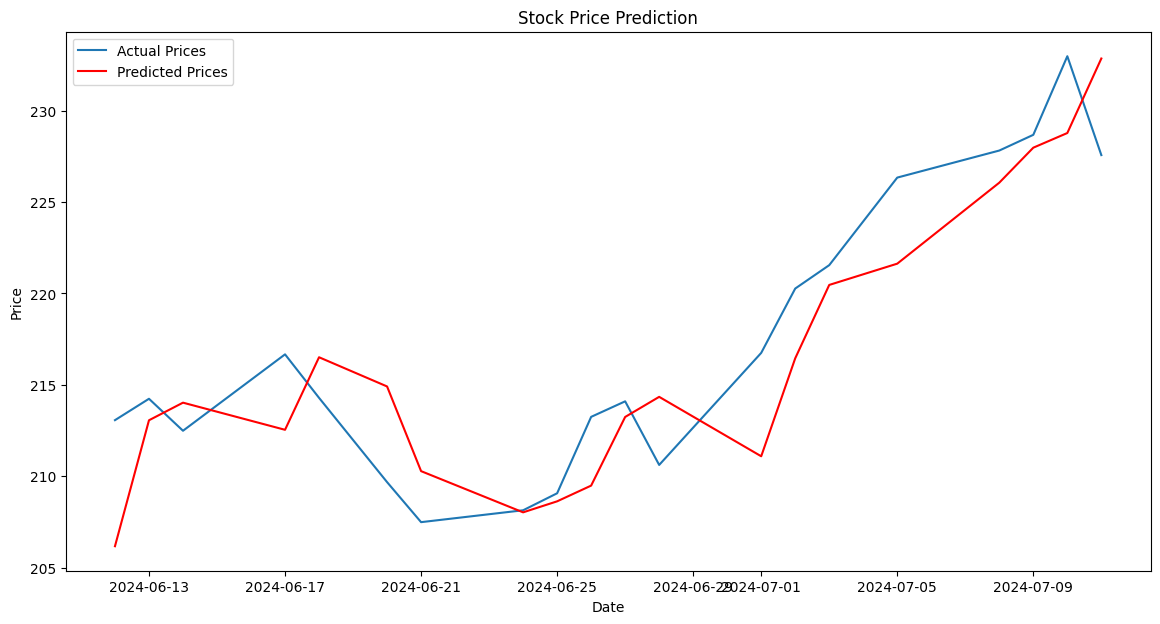

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(dataset.index[-20:], dataset['Close'][-20:], label='Actual Prices')
plt.plot(dataset.index[-20:], y_pred_test[-20:], label='Predicted Prices', color='red')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

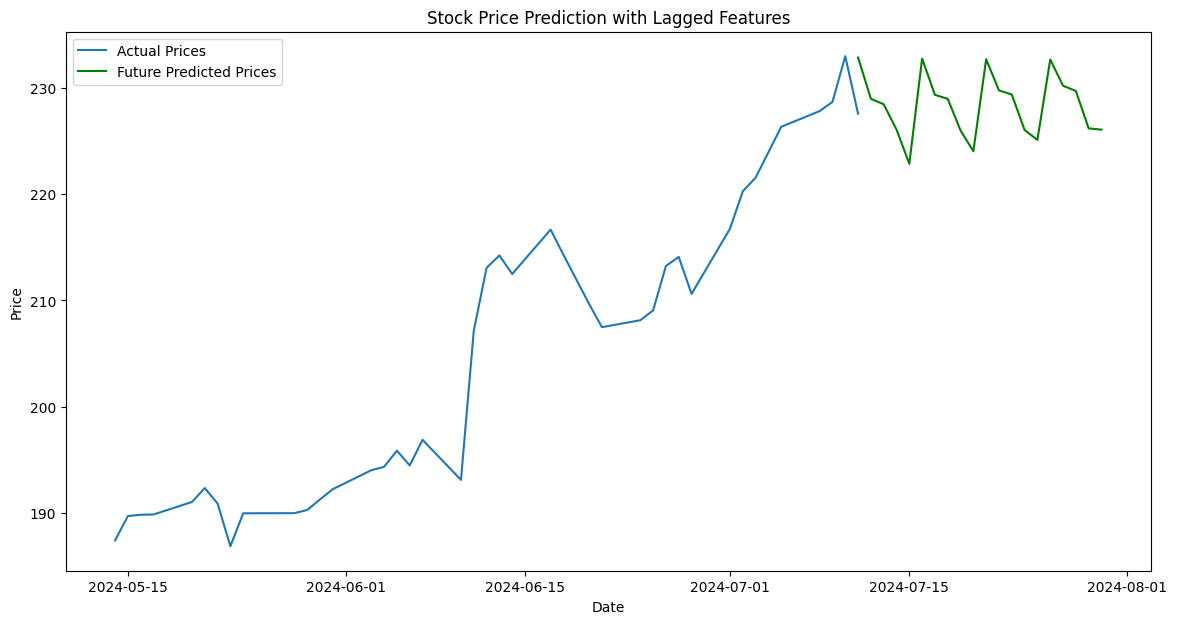

In [ ]:
future_days = 20

last_known_data = X.iloc[-1].values.reshape(1, -1)
future_predictions = []

for i in range(future_days):
    future_pred = lr.predict(last_known_data)[0]
    future_predictions.append(future_pred)

    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, -1] = future_pred

last_date = dataset.index[-1]
future_dates = pd.date_range(last_date, periods=future_days)

future_df = pd.DataFrame({
    'Predicted_Close': future_predictions
}, index=future_dates)

plt.figure(figsize=(14, 7))
plt.plot(dataset.index[-40:], dataset['Close'][-40:], label='Actual Prices')
plt.plot(future_df.index[-40:], future_df['Predicted_Close'][-40:], label='Future Predicted Prices', color='green')
plt.legend()
plt.title('Stock Price Prediction with Lagged Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Approach 1.2 - Multiple Lagged Features

In [ ]:
# Create technical indicators
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['Daily_Return'] = data['Close'].pct_change() * 100
data['Volume_Change'] = data['Volume'].pct_change() * 100

# Create lagged features
look_back = 5
for i in range(1, look_back + 1):
    data[f'Lag_{i}'] = data['Close'].shift(i)

# Create date features
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month


<ipython-input-51-30d320f82375>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_5'] = data['Close'].rolling(window=5).mean()
<ipython-input-51-30d320f82375>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_10'] = data['Close'].rolling(window=10).mean()
<ipython-input-51-30d320f82375>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [ ]:
# Drop rows with NaN values (due to lagged features and rolling calculations)
data.dropna(inplace=True)

# Features and target
feature_columns = ['SMA_5', 'SMA_10', 'Daily_Return', 'Volume_Change',
                   'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'DayOfWeek', 'Month']
X = data[feature_columns]
y = data['Close']

<ipython-input-60-2ed08324c018>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


<Axes: >

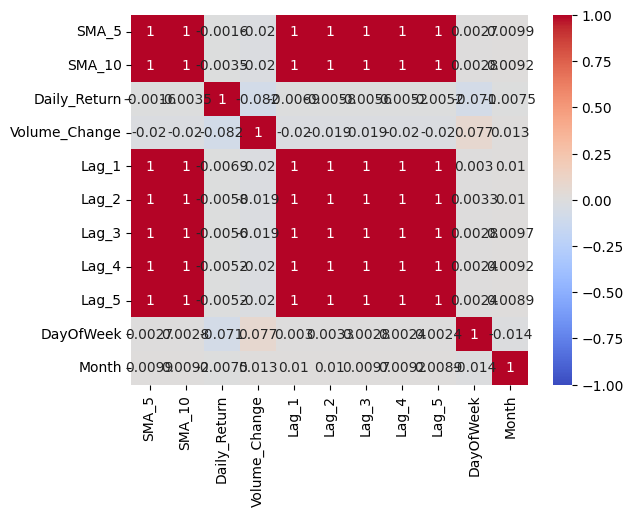

In [ ]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [ ]:
# Features and target
feature_columns = ['SMA_10', 'Daily_Return', 'Volume_Change', 'DayOfWeek', 'Month']
X = data[feature_columns]
y = data['Close']

<Axes: >

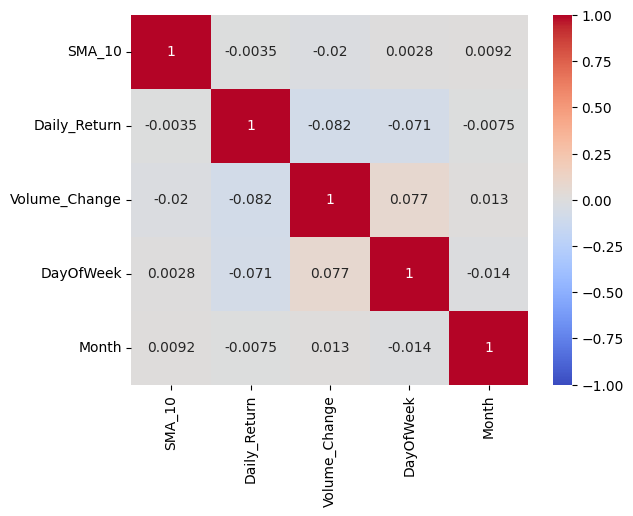

In [ ]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [ ]:
# Sequentially split data (80% train, 20% test)
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = metrics.mean_squared_error(y_train, model.predict(X_train))
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 2.6774484221603636
Test MSE: 20.502523465545604


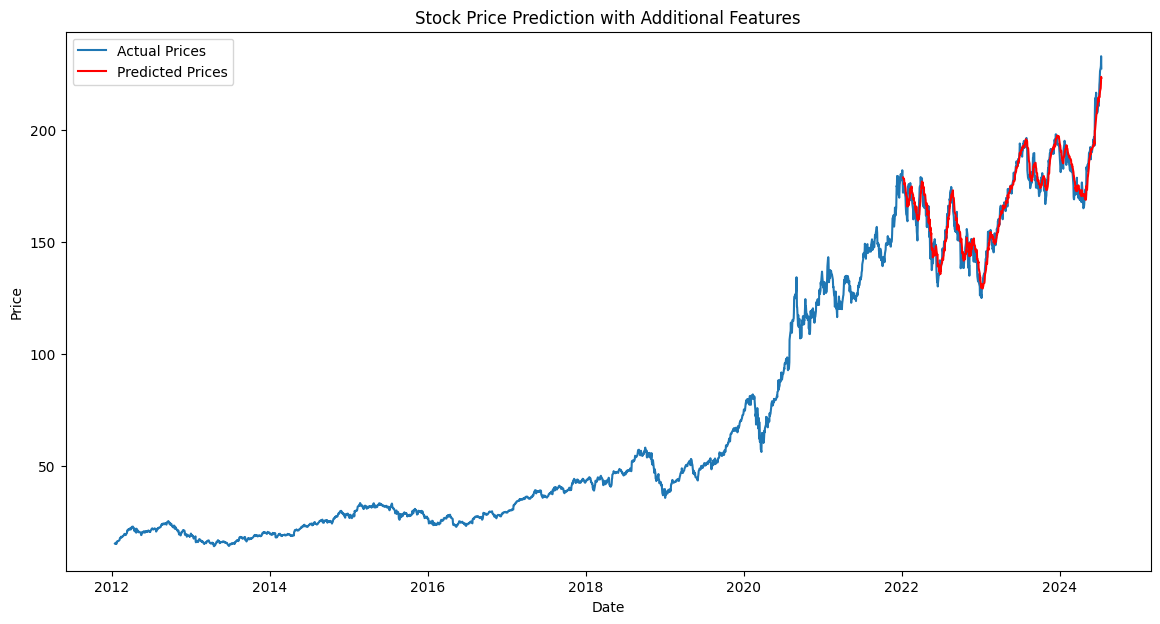

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Prices')
plt.plot(data.index[train_size:], y_pred_test, label='Predicted Prices', color='red')
plt.legend()
plt.title('Stock Price Prediction with Additional Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

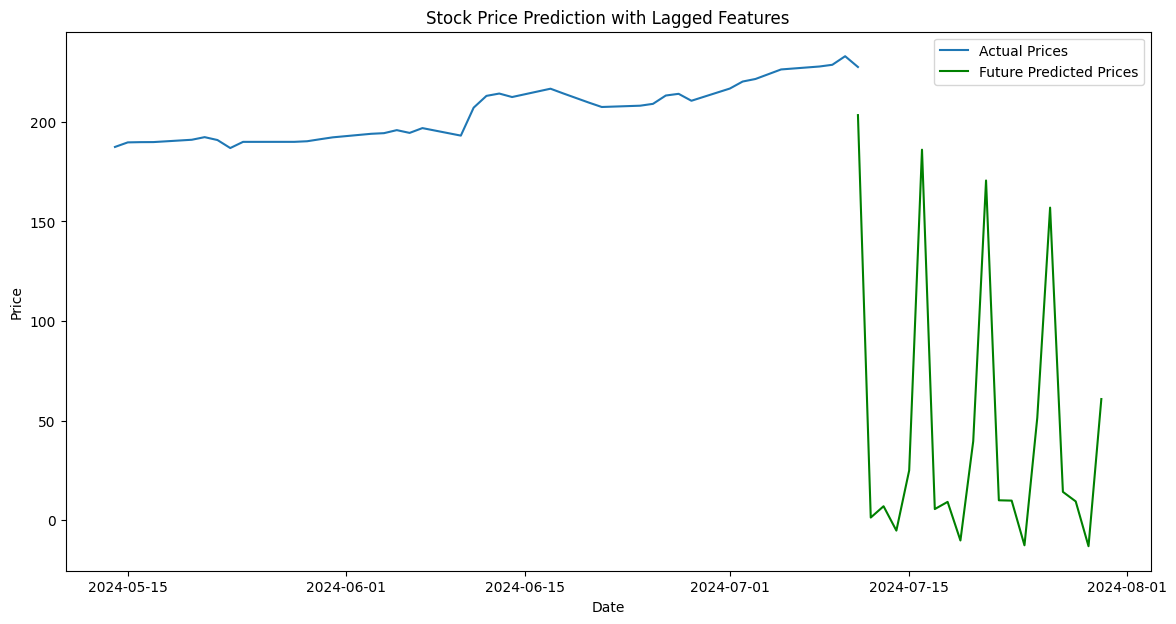

In [ ]:
future_days = 20

last_known_data = X.iloc[-1].values.reshape(1, -1)
future_predictions = []

for i in range(future_days):
    future_pred = lr.predict(last_known_data)[0]
    future_predictions.append(future_pred)

    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, -1] = future_pred

last_date = dataset.index[-1]
future_dates = pd.date_range(last_date, periods=future_days)

future_df = pd.DataFrame({
    'Predicted_Close': future_predictions
}, index=future_dates)

plt.figure(figsize=(14, 7))
plt.plot(dataset.index[-40:], dataset['Close'][-40:], label='Actual Prices')
plt.plot(future_df.index[-40:], future_df['Predicted_Close'][-40:], label='Future Predicted Prices', color='green')
plt.legend()
plt.title('Stock Price Prediction with Lagged Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()